### Problem Statement
An international humanitarian NGO has got a $ 10 million fuding. The CEO needs to decide how to use this money effectively and strategically. The significant choice at hand is the countries that are in dire need of aid.

We need to be able to categorise countries using some socio-economic and health factors that determine the overall development of the country.This will help the CEO to understand where to focus the most.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import uniform
from math import isnan
from random import sample

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import warnings
warnings.filterwarnings('ignore')

The Broad set of steps we will follow are as below:
1. Read and Understand the data
    - convert percentage data to original data
2. EDA 
    - Clean and visualize the data 
    - Univariate Analysis
    - Bivariate analysis
3. Data Preparation for Modelling
    - Missing value and Outlier checking
    - Outlier Treatment
    - Scaling the variables
    - Check the data for clusterability - Hopkins metric
4. Modelling
    - Hierarchical Clustering
5. Analysis of the model and Recommendations
    - Cluster profiling
    

# Step 1: Read and Understand the data

In [4]:
country_df = pd.read_csv("../data/Poverty Alleviation Country.csv")
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
# Check the data shape
country_df.shape

(167, 10)

In [6]:
# check for data types and any missing values
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [7]:
# Checking if there are any duplicte countries
len(country_df['country'].unique())

167

In [8]:
# Do a statistical analysis of all the numerical columns
country_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


**The Data description given is as below:**

|Column Name	       |      Description<br>                                   |
|:---                  |:---                                                    |
|country	           |      Name of the country                               |
|child_mort	           |  Death of children under 5 years of age per 1000 live births|
|exports	           |     Exports of goods and services per capita. Given as %age of the GDP per capita|
|health	               |  Total health spending per capita. Given as %age of GDP per capita|
|imports	           |      Imports of goods and services per capita. Given as %age of the GDP per capita|
|Income	               |  Net income per person|
|Inflation             |   The measurement of the annual growth rate of the Total GDP|
|life_expec	           |  The average number of years a new born child would live if the current mortality patterns are to remain the same|  
|total_fer	           |  The number of children that would be born to each woman if the current age-fertility    rates remain the same.|
|gdpp	               |  The GDP per capita. Calculated as the Total GDP divided by the total population.|

Note: exports, health and imports are given as percentages of GDPP. would need to get the original value for clustering to consider their effect correctly

In [9]:
#Convert exports, health and imports to absolute values
percent_vars =['exports', 'health', 'imports']

for var in percent_vars:
    country_df[var] = (country_df[var]/100)* country_df['gdpp']
    
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


#### Observations:
1. All data is numerical continuous data, except country which acts as the key
2. We have data for 167 countries
3. Exports, health and imports are given as a % of GDPP and hence converted back to absolute values

# Step 2: Data Cleansing

### Check for NULLs

In [11]:
df_null = country_df.isna().mean()*100
df_null

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

### Check for Duplicates

In [14]:
country_df.loc[country_df.duplicated()]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp


# Step 3: Exploratory Data Analysis 
## Univariate Analysis
### For Continuous variables

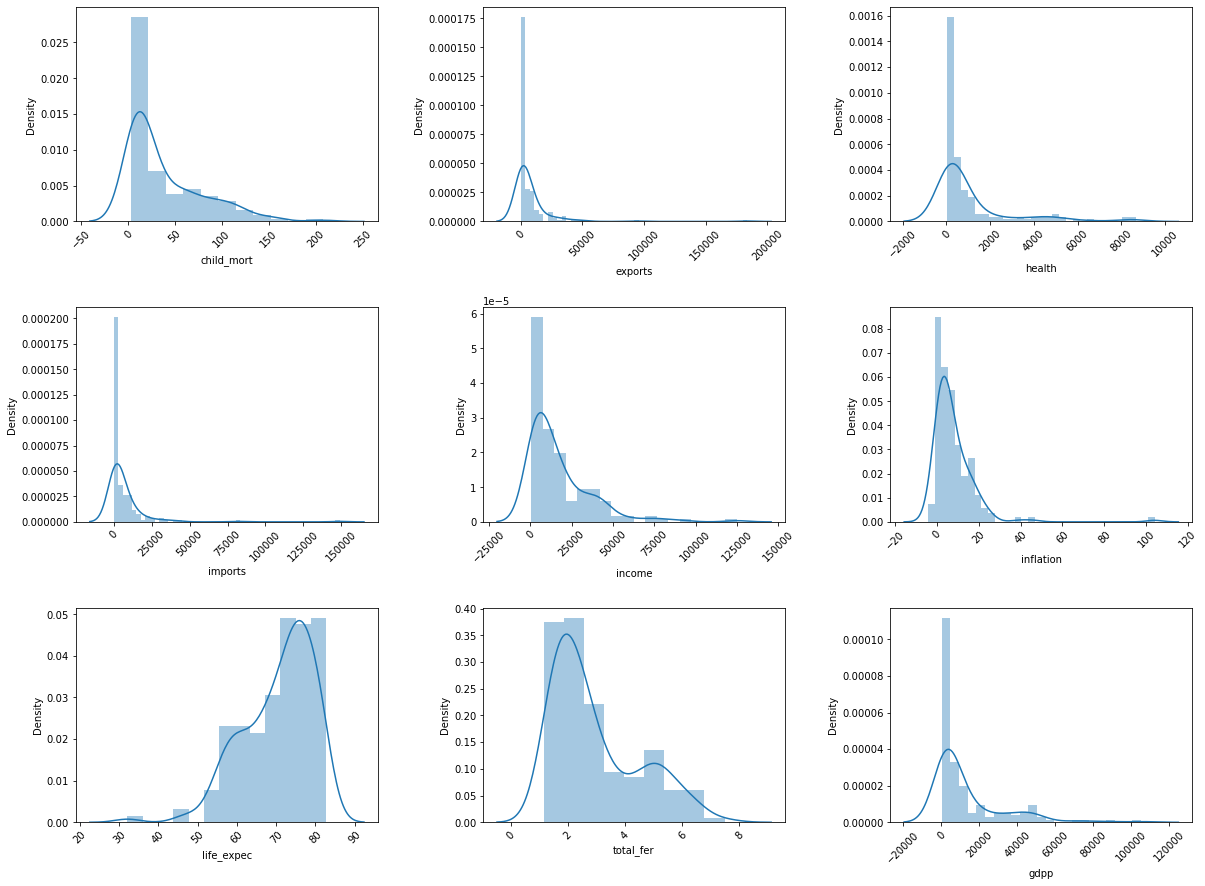

In [15]:
# plot histograms for all continuous variable to understand their distribution and 
# get an idea of which variables are going to influence clustering

cont_vars = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']

plt.figure(figsize=[20,15])
plt.subplots_adjust(hspace=0.40,wspace=0.35)
for i,col in enumerate(cont_vars):
    plt.subplot(3,3,i+1)
    sns.distplot(country_df[col],hist=True)
    plt.xticks(rotation=45)
    plt.ylabel("Density")
    
plt.show()

Note: None of them are a complete normal curve. 

Most are left skewed implying a large number of countries probably are in that cluster and there are a small number in the far right cluster.
1. Child Mortality
2. Exports
3. Health
4. Imports
5. Income 
6. Inflation

Life expectancy, total fertility, income and gdpp show there are visible clusters

## Bivariate Analysis

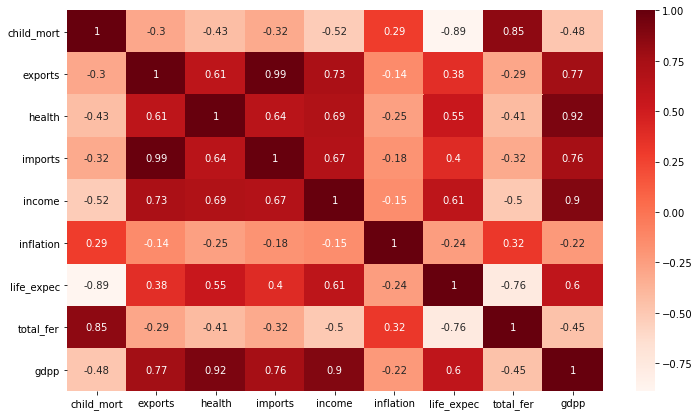

In [16]:
# Plotting a heat map to understand which variables are correlated and would add positively together to a cluster
plt.figure(figsize = [12, 7])
sns.heatmap(country_df.corr(), annot=True, cmap='Reds')

plt.show()

**Observations:**
1. There clearly is a high positive correlation between GDPP and income, life expectancy, exports, health and imports.
2. There is a negative correlation between GDPP with Total fertility, Child Mortality and inflation
3. Exports, imports and health are highly correlated 
4. Health is negatively correlated with Total Fertility, Inflation and Child Moratality
5. There is a strong correlation positive betweeen Total fertility and Child mortality
6. Also a positive correlation between income and life expectancy

**Conclusion:**: we have a good chunk of correlated data that should help in creating clusters

<Figure size 864x1080 with 0 Axes>

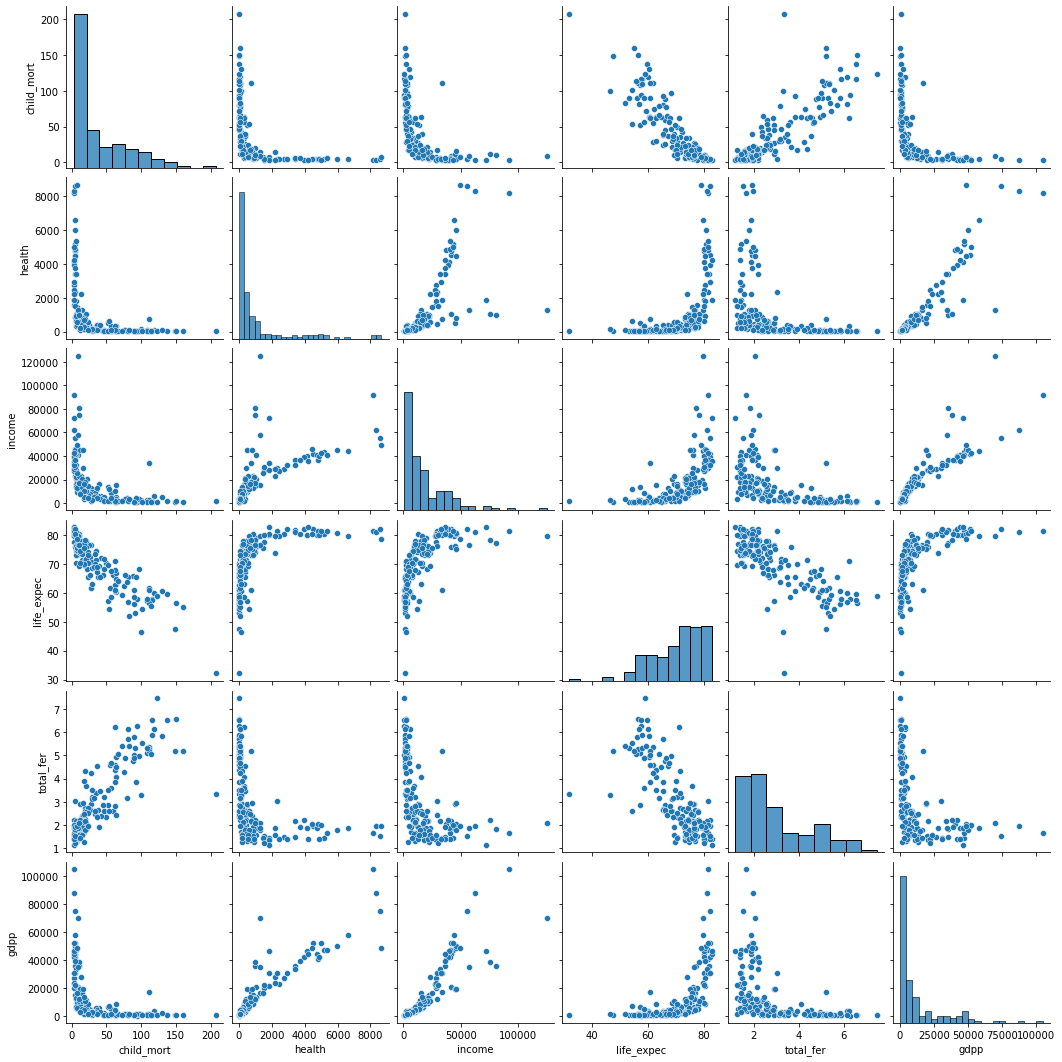

In [17]:
# Pair plot to understand if there are visible clusters 

plt.figure(figsize = [12, 15])
sns.pairplot(data=country_df[['child_mort','health','income','life_expec','total_fer','gdpp']])

plt.show()

# Step 4: Data Preparation 
## Missing Value check and treatment

In [18]:
# Check for missing values
country_df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

There are no missing values and hence no treatment required

## Outlier checks and Treatment

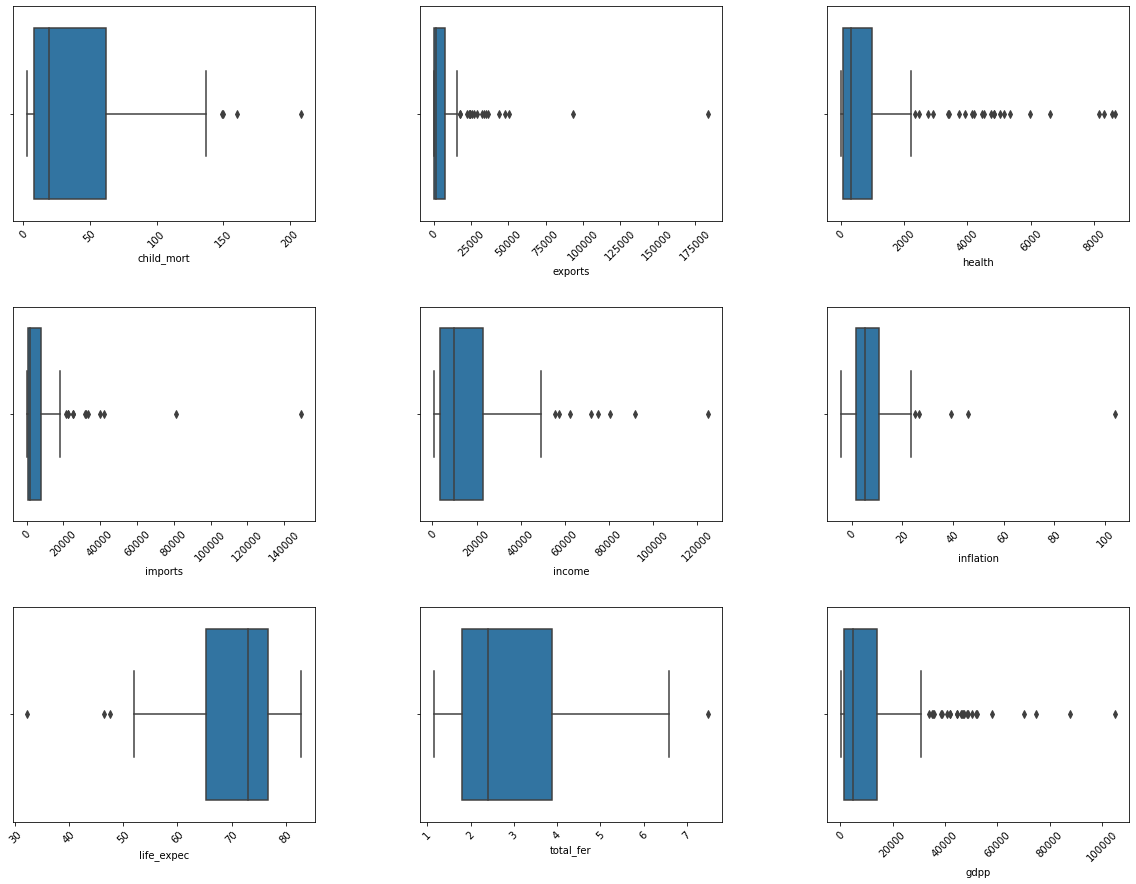

In [19]:
# Check for spread and outliers

cont_vars = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']

plt.figure(figsize=[20,15])
plt.subplots_adjust(hspace=0.40,wspace=0.35)
for i,col in enumerate(cont_vars):
    plt.subplot(3,3,i+1)
    sns.boxplot(country_df[col], orient="v")
    plt.xticks(rotation=45)
    
plt.show()

#### Checking for various quantile values to decide how much to cap 

In [20]:
country_df['income'].quantile([0.75,0.85,0.90,0.95,0.99,0.995,1.0])

0.750     22800.0
0.850     36200.0
0.900     41220.0
0.950     48290.0
0.990     84374.0
0.995     97361.0
1.000    125000.0
Name: income, dtype: float64

In [21]:
country_df['gdpp'].quantile([0.75,0.85,0.90,0.95,0.99,0.995,1.0])

0.750     14050.0
0.850     31090.0
0.900     41840.0
0.950     48610.0
0.990     79088.0
0.995     90724.0
1.000    105000.0
Name: gdpp, dtype: float64

In [22]:
country_df['exports'].quantile([0.75,0.85,0.90,0.95,0.99,1.0])

0.75      7278.00
0.85     12667.23
0.90     17760.60
0.95     31385.10
0.99     64794.26
1.00    183750.00
Name: exports, dtype: float64

In [23]:
country_df['imports'].quantile([0.75,0.85,0.90,0.95,0.99,1.0])

0.75      7719.60
0.85     11434.14
0.90     15034.28
0.95     24241.56
0.99     55371.39
1.00    149100.00
Name: imports, dtype: float64

In [24]:
country_df['inflation'].quantile([0.75,0.85,0.90,0.95,0.99,0.995,1.0])

0.750     10.750
0.850     15.330
0.900     16.640
0.950     20.870
0.990     41.478
0.995     55.777
1.000    104.000
Name: inflation, dtype: float64

In [25]:
country_df['life_expec'].quantile([0.00,0.005,0.01,0.05,0.10,0.5,0.75,0.99,1.0])

0.000    32.100
0.005    44.052
0.010    47.160
0.050    55.780
0.100    57.820
0.500    73.100
0.750    76.800
0.990    82.370
1.000    82.800
Name: life_expec, dtype: float64

In [26]:
country_df['child_mort'].quantile([0.75,0.85,0.90,0.95,0.99,0.995,1.0])

0.750     62.10
0.850     88.31
0.900    100.22
0.950    116.00
0.990    153.40
0.995    168.16
1.000    208.00
Name: child_mort, dtype: float64


**NOTE:** 
Need to be watchful of capping the high end values of data like inflation, child mortality 
and lower end values of life expectency as the needy countries should not lose out on aid due to this. 

However, it is safe to cap the higher end values of income, exports, imports, gdpp.
Hence choosing to cap higher end at 0.99 quantile and lower end to 0.1 quantile

Not capping 'health' as it has almost continuous values outside the 100th percentile and that itself could contribute to a cluster

In [27]:
# For those with outliers in the top end, will cap them to 99 percentile
cap_99_vars = ['child_mort','exports','imports','income','inflation','total_fer','gdpp']

for var in cap_99_vars:
    q4 = country_df[var].quantile(0.99)
    country_df[var][country_df[var] >= q4] = q4

In [28]:
# check the impact after capping
country_df[cap_99_vars].describe()

,child_mort,exports,imports,income,inflation,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,37.903593,6538.214776,5873.135222,16857.550898,7.380970,2.942259,12756.826347
std,39.027880,11415.308590,9422.700869,17957.012855,7.793224,1.498340,17430.208938
min,2.600000,1.076920,0.651092,609.000000,-4.210000,1.150000,231.000000
25%,8.250000,447.140000,640.215000,3355.000000,1.810000,1.795000,1330.000000
50%,19.300000,1777.440000,2045.580000,9960.000000,5.390000,2.410000,4660.000000
75%,62.100000,7278.000000,7719.600000,22800.000000,10.750000,3.880000,14050.000000
max,153.400000,64794.260000,55371.390000,84374.000000,41.478000,6.563600,79088.000000


In [29]:
# Life expectency has an outlier at the lower end and hence will be capped at 0.01 percentile
q1 = country_df['life_expec'].quantile(0.01)
country_df['life_expec'][country_df['life_expec'] <= q1] = q1

country_df['life_expec'].describe()

count    167.00000
mean      70.64982
std        8.56035
min       47.16000
25%       65.30000
50%       73.10000
75%       76.80000
max       82.80000
Name: life_expec, dtype: float64

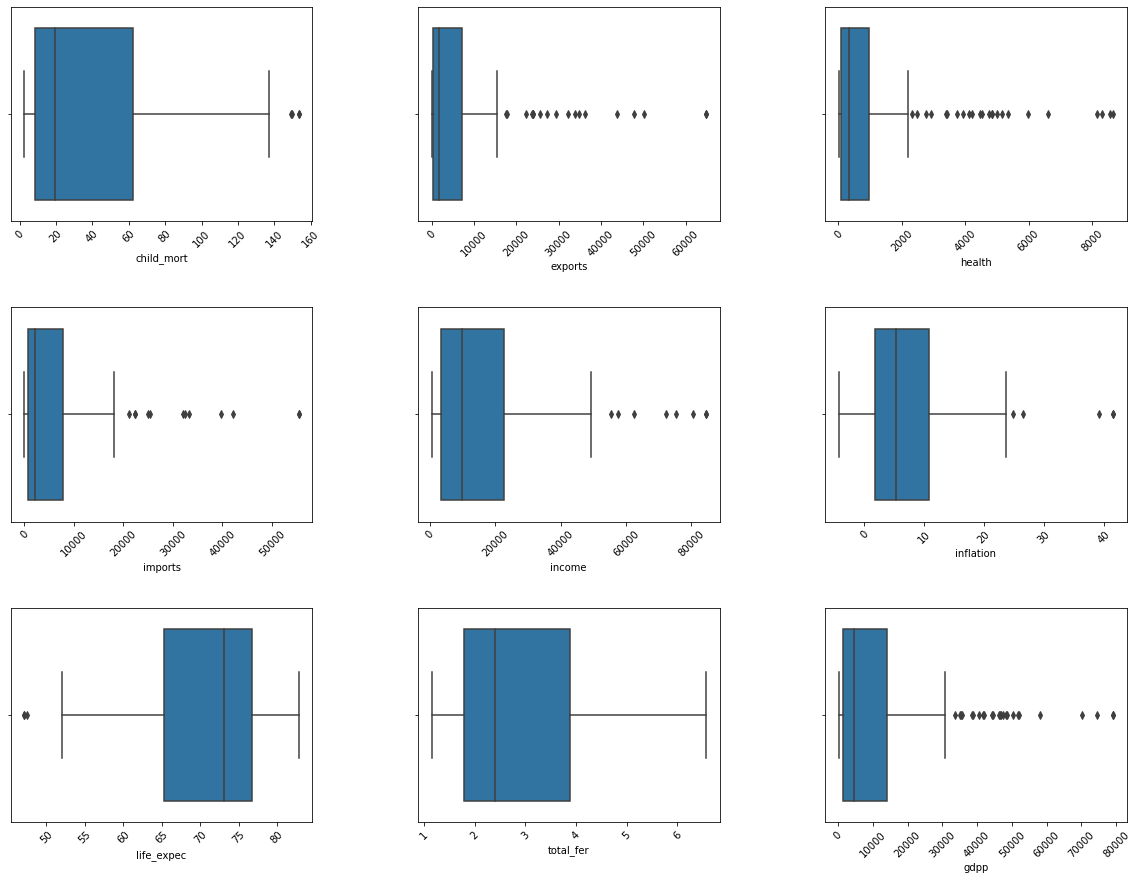

In [30]:
# Check for spread and outliers after treatment

cont_vars = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']

plt.figure(figsize=[20,15])
plt.subplots_adjust(hspace=0.40,wspace=0.35)
for i,col in enumerate(cont_vars):
    plt.subplot(3,3,i+1)
    sns.boxplot(country_df[col], orient="v")
    plt.xticks(rotation=45)
    
plt.show()

## Scale the variables

In [31]:
# Prepare data for scaling
data_to_scale = country_df.drop('country', axis=1)
data_to_scale.head() 

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0
1,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0
2,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0
3,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0
4,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0


In [32]:
# use the standard scaler for scaling
scaler = StandardScaler()
country_scaled = scaler.fit_transform(data_to_scale)
country_scaled = pd.DataFrame(country_scaled)
country_scaled.columns = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']
country_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.344006,-0.569622,-0.565040,-0.598741,-0.851668,0.265002,-1.693071,1.926396,-0.702259
1,-0.547497,-0.473858,-0.439218,-0.413584,-0.386946,-0.372075,0.662026,-0.865054,-0.498726
2,-0.272510,-0.424000,-0.484826,-0.476100,-0.221053,1.122161,0.685460,-0.034983,-0.477434
3,2.084159,-0.381249,-0.532363,-0.463973,-0.612045,1.932987,-1.236112,2.153997,-0.530950
4,-0.709406,-0.086742,-0.178771,0.139728,0.125254,-0.764618,0.720610,-0.543736,-0.032042


## Check for Cluster Tendency - Hopkins Test

In [33]:
# define the Hopkins function
def hopkins(X):
    d = X.shape[1]
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [35]:
hopkins(country_scaled)

0.899210745355562

On multiple runs, the Hopkins metric is ranging from 0.8 to 0.95 and hence there is a good cluster tendency

# Step 5: Modelling

## Step 5-a: Hierarchical Clustering

### Single Linkage

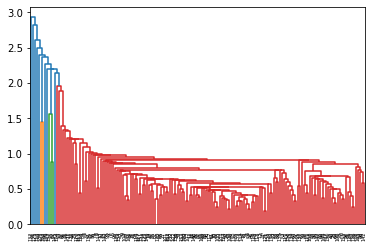

In [36]:
# single linkage
h_model_1 = linkage(country_scaled, method="single", metric='euclidean')
dendrogram(h_model_1)
plt.show()

###  Complete Linkage

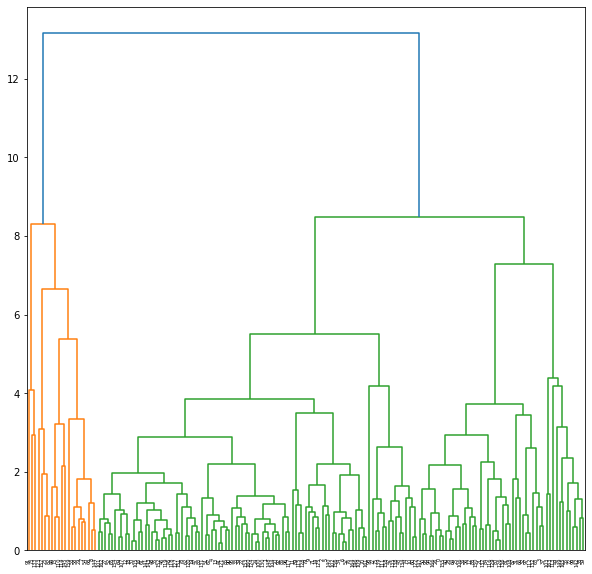

In [37]:
# complete linkage
plt.figure(figsize = [10,10])
h_model_2 = linkage(country_scaled, method="complete", metric='euclidean')
dendrogram(h_model_2)
plt.show()

In [38]:
# 3 clusters - hierarchical clustering
h_cluster_id = cut_tree(h_model_2, n_clusters=3).reshape(-1, )
h_cluster_id

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       2, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 1, 2, 1, 1, 1, 0, 1, 0, 0])

In [39]:
# assign cluster labels
country_hier3 = country_df.copy()
country_hier3['cluster_id'] = h_cluster_id
country_hier3.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,1


In [40]:
country_hier3['cluster_id'].value_counts()

1    96
0    50
2    21
Name: cluster_id, dtype: int64

## Step 5-b: Cluster Profiling for Hierarchical clustering (Cut off 3) 

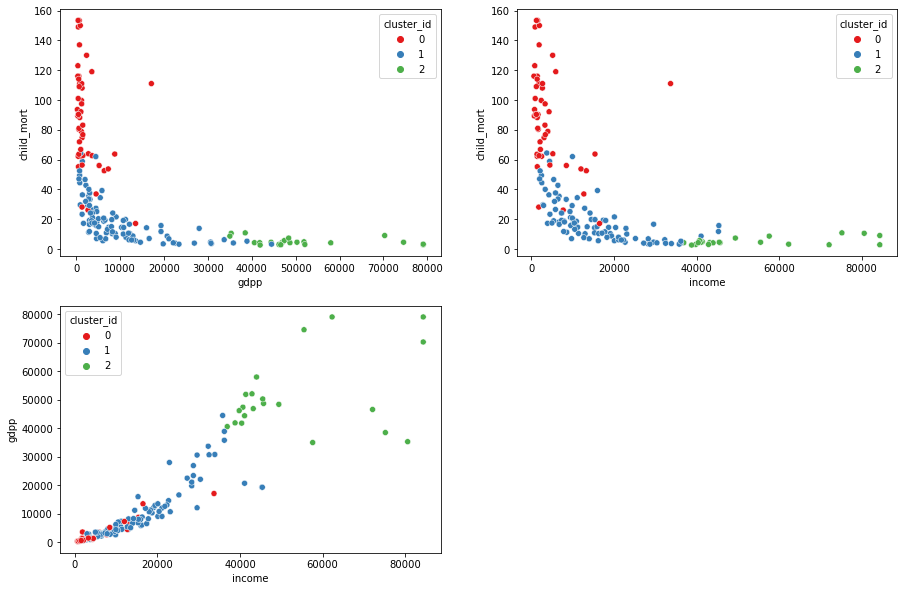

In [41]:
# Plot the scatter plot for the 3 important variables: income, GDPP and child Mortality along with clusters

plt.figure(figsize = [15,10])
plt.subplot(2,2,1)
sns.scatterplot(x = "gdpp" , y = "child_mort", hue = 'cluster_id', data = country_hier3, palette = "Set1", legend = "full")
plt.subplot(2,2,2)
sns.scatterplot(x = "income" , y = "child_mort", hue = 'cluster_id', data = country_hier3, palette = "Set1",legend = "full")
plt.subplot(2,2,3)
sns.scatterplot(x = "income" , y = "gdpp", hue = 'cluster_id', data = country_hier3, palette = "Set1", legend = "full")

plt.show()

<AxesSubplot:xlabel='cluster_id'>

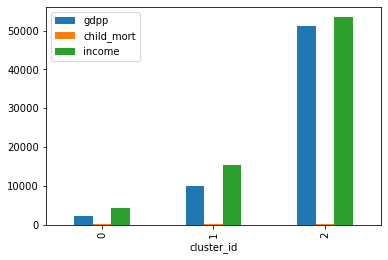

In [42]:
# view the average of the GDPP, Child Mortatlity and Income by cluster

country_hier3.groupby('cluster_id')['gdpp','child_mort','income'].mean().plot(kind = 'bar')

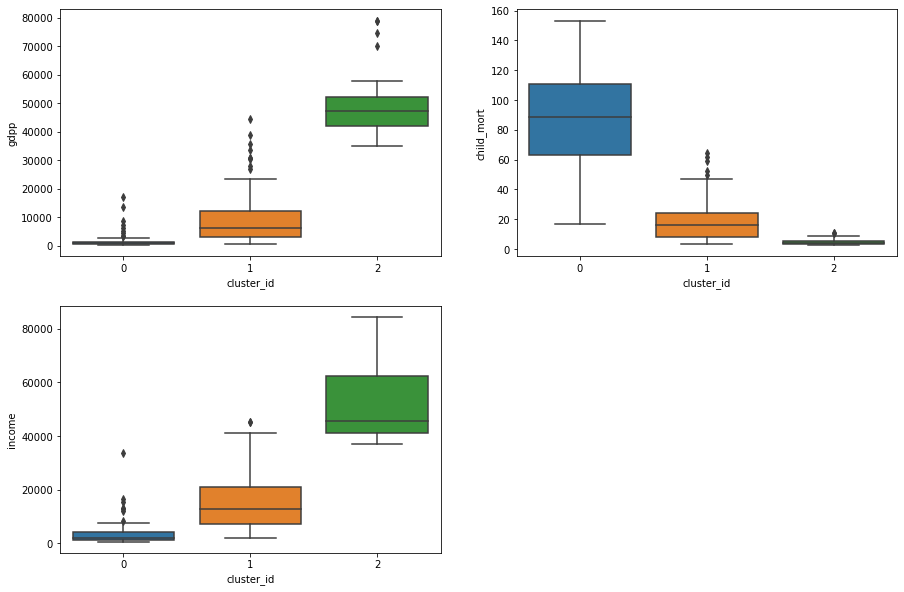

In [43]:
# View a box plots to see how distinct the clusters are
plt.figure(figsize = [15,10])
plt.subplot(2,2,1)
sns.boxplot(x='cluster_id', y = 'gdpp', data = country_hier3 )
plt.subplot(2,2,2)
sns.boxplot(x='cluster_id', y = 'child_mort', data = country_hier3 )
plt.subplot(2,2,3)
sns.boxplot(x='cluster_id', y = 'income', data = country_hier3 )
plt.show()

In [44]:
# Again here, it is the cluster 0 that we are interested in
country_hier3[country_hier3['cluster_id'] == 0].sort_values(by = ['gdpp', 'child_mort', 'income'], ascending = [True,False,True])

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.300,57.70,6.2600,231.0,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.470,60.80,5.0200,327.0,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.800,57.50,6.5400,334.0,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.550,58.80,6.5636,348.0,0
132,Sierra Leone,153.4,67.0320,52.2690,137.655,1220.0,17.200,55.00,5.2000,399.0,0
93,Madagascar,62.2,103.2500,15.5701,177.590,1390.0,8.790,60.80,4.6000,413.0,0
106,Mozambique,101.0,131.9850,21.8299,193.578,918.0,7.640,54.50,5.5600,419.0,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888.0,2.010,47.50,5.2100,446.0,0
94,Malawi,90.5,104.6520,30.2481,160.191,1030.0,12.100,53.10,5.3100,459.0,0
50,Eritrea,55.2,23.0878,12.8212,112.306,1420.0,11.600,61.70,4.6100,482.0,0


**Observations:**

- Again here, the cluster 0 has 50 countries all with lower income and GDPP and higher child mortality rate.
- Considering that the problem is that of Socio Economic and health factors, we get a very similar set of countries ordering them by GDPP, Child Mortality and Income with in this cluster
- Considering that this is a very large cluster, I would like to reduce the number by taking at cut at 5 clusters

In [45]:
country_hier3.cluster_id.value_counts()

1    96
0    50
2    21
Name: cluster_id, dtype: int64

NOTE: The under developed countries are 50, developing are 96 and developed are 21

## Step 5-c: Hierarchical clustering with cut off at 5

In [46]:
# 5 clusters - hierarchical clustering
h_cluster_id_5 = cut_tree(h_model_2, n_clusters=5).reshape(-1, )
h_cluster_id_5

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 3, 1, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 3, 0, 1, 1, 2, 2, 3, 0, 1, 2, 3, 1, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 3, 4, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 1, 4, 1, 0, 0, 1, 1, 0, 1, 3, 1, 1, 1, 3, 1, 1, 0, 1, 0, 1,
       2, 1, 0, 3, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 4, 1, 1, 0, 0, 1, 1, 1, 1, 3, 1, 2, 2, 1, 0, 1, 3, 0, 1, 1, 1,
       1, 0, 1, 2, 1, 2, 1, 1, 1, 3, 1, 3, 0])

In [47]:
# assign cluster labels
country_hier5 = country_df.copy()
country_hier5['cluster_id'] = h_cluster_id_5
country_hier5.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,1


## Step 5-d: Cluster Profiling for Hierarchical clustering (Cut off 5)

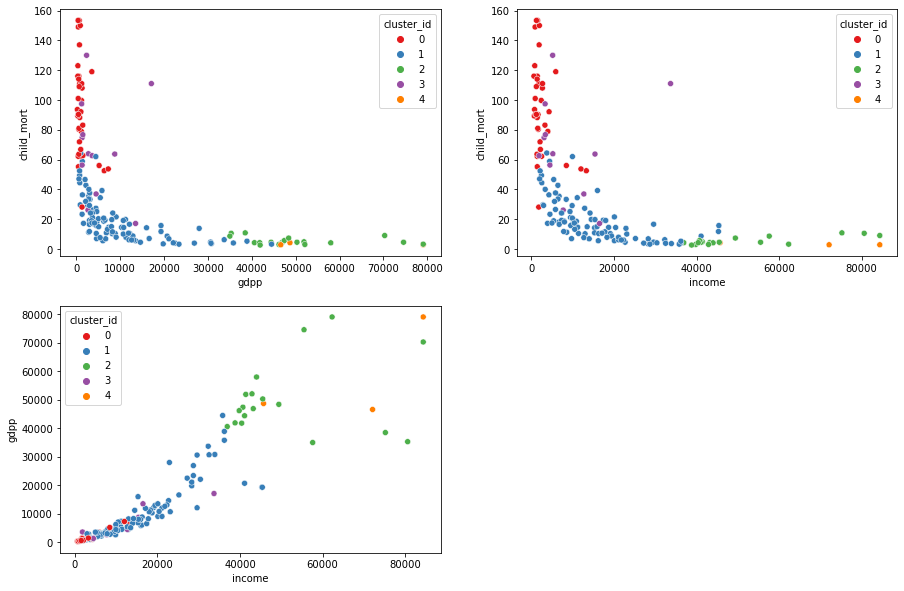

In [48]:
# Plot the scatter plot for the 3 important variables: income, GDPP and child Mortality along with clusters

plt.figure(figsize = [15,10])
plt.subplot(2,2,1)
sns.scatterplot(x = "gdpp" , y = "child_mort", hue = 'cluster_id', data = country_hier5, palette = "Set1", legend = "full")
plt.subplot(2,2,2)
sns.scatterplot(x = "income" , y = "child_mort", hue = 'cluster_id', data = country_hier5, palette = "Set1",legend = "full")
plt.subplot(2,2,3)
sns.scatterplot(x = "income" , y = "gdpp", hue = 'cluster_id', data = country_hier5, palette = "Set1", legend = "full")

plt.show()

<AxesSubplot:xlabel='cluster_id'>

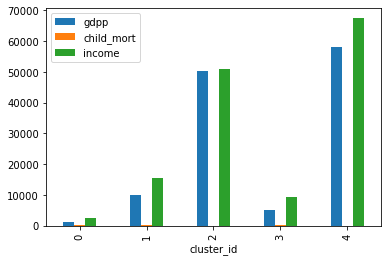

In [49]:
country_hier5.groupby('cluster_id')['gdpp','child_mort','income'].mean().plot(kind = 'bar')

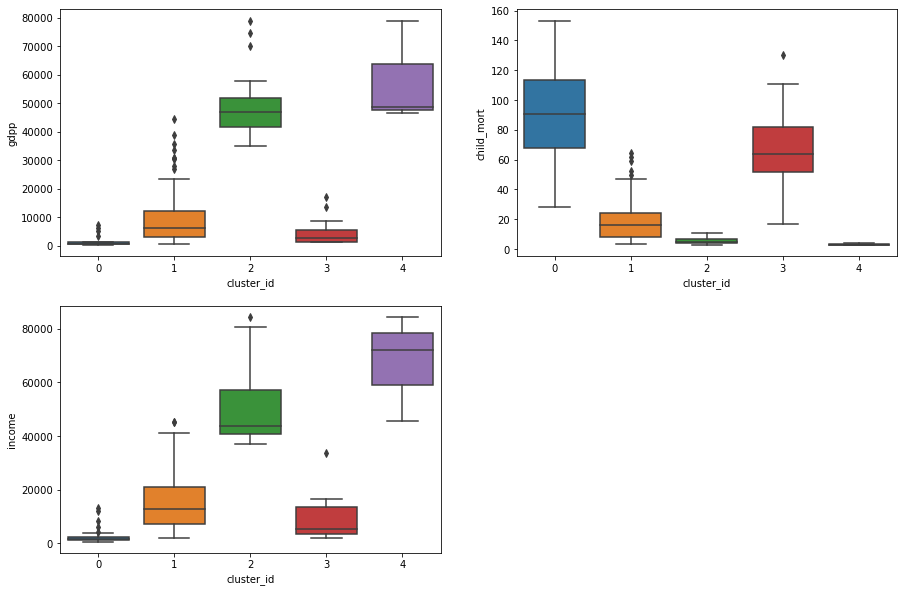

In [50]:
# View a box plots to see how distinct the clusters are
plt.figure(figsize = [15,10])
plt.subplot(2,2,1)
sns.boxplot(x='cluster_id', y = 'gdpp', data = country_hier5 )
plt.subplot(2,2,2)
sns.boxplot(x='cluster_id', y = 'child_mort', data = country_hier5 )
plt.subplot(2,2,3)
sns.boxplot(x='cluster_id', y = 'income', data = country_hier5 )
plt.show()

**Observations:**
- Now cluster 0 seems the most needy and has come down to 38 countries compared to 50 earlier
- Some of the lesser needy ones but still needy have formed the cluster 3, which can be addressed later


In [51]:
country_hier5['cluster_id'].value_counts()

1    96
0    38
2    18
3    12
4     3
Name: cluster_id, dtype: int64

NOTE: 
- Now we have 38 countries that are most Needy
- There are 12 more in another cluster that are next level of needy countries
- 96 are grouped into what can be called as Developing countries
- 12 are developed countries
- 3 top developed countries are Luxembourg, Singapore and Ireland, which is not of much consequence to this analysis

However, since we now have split the under developed into a cluster of 38 and 12, the 38 countries can be looked at initially

In [52]:
# The 38 countries that need the aid urgently are shown here
country_hier5[country_hier5['cluster_id'] == 0]\
.sort_values(by = ['gdpp', 'child_mort', 'income'], ascending = [True,False,True])

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.300,57.70,6.2600,231.0,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.470,60.80,5.0200,327.0,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.800,57.50,6.5400,334.0,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.550,58.80,6.5636,348.0,0
132,Sierra Leone,153.4,67.0320,52.2690,137.655,1220.0,17.200,55.00,5.2000,399.0,0
93,Madagascar,62.2,103.2500,15.5701,177.590,1390.0,8.790,60.80,4.6000,413.0,0
106,Mozambique,101.0,131.9850,21.8299,193.578,918.0,7.640,54.50,5.5600,419.0,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888.0,2.010,47.50,5.2100,446.0,0
94,Malawi,90.5,104.6520,30.2481,160.191,1030.0,12.100,53.10,5.3100,459.0,0
50,Eritrea,55.2,23.0878,12.8212,112.306,1420.0,11.600,61.70,4.6100,482.0,0


# Final Conclusions

### The list of countries that need aid - by Hierarchical Clustering with cut off at 5
- This consists of 38 countries
- The other 12 countries in the list with cutoff at 3 have moved to a new cluster

### This list of 38 countries could be considered for aid. 
### With the top 5-10 getting the highest priority in allocation 

In [53]:
country_hier5[country_hier5['cluster_id'] == 0]\
.sort_values(by = ['gdpp', 'child_mort', 'income'], ascending = [True,False,True])['country']

26                      Burundi
88                      Liberia
37             Congo, Dem. Rep.
112                       Niger
132                Sierra Leone
93                   Madagascar
106                  Mozambique
31     Central African Republic
94                       Malawi
50                      Eritrea
150                        Togo
64                Guinea-Bissau
0                   Afghanistan
56                       Gambia
126                      Rwanda
25                 Burkina Faso
155                      Uganda
63                       Guinea
66                        Haiti
147                    Tanzania
97                         Mali
17                        Benin
36                      Comoros
32                         Chad
80                        Kenya
129                     Senegal
116                    Pakistan
84                          Lao
87                      Lesotho
40                Cote d'Ivoire
136             Solomon Islands
28      

### After discussion with the CEO, if we concur that Child mortatlity is of greater importance to be addressed rather then just GDPP and income, the order of top 10 countries would change to

In [54]:
country_hier5[country_hier5['cluster_id'] == 0]\
.sort_values(by = ['child_mort','gdpp', 'income'], ascending = [False,True,True])['country']

132                Sierra Leone
66                        Haiti
32                         Chad
31     Central African Republic
97                         Mali
112                       Niger
3                        Angola
37             Congo, Dem. Rep.
25                 Burkina Faso
64                Guinea-Bissau
17                        Benin
40                Cote d'Ivoire
63                       Guinea
28                     Cameroon
106                  Mozambique
87                      Lesotho
26                      Burundi
116                    Pakistan
94                       Malawi
150                        Togo
0                   Afghanistan
88                      Liberia
36                      Comoros
166                      Zambia
155                      Uganda
56                       Gambia
84                          Lao
147                    Tanzania
129                     Senegal
126                      Rwanda
81                     Kiribati
93      